In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from modeling.models.bethge import BethgeModel
from torch.utils.data import TensorDataset, DataLoader
from skimage.io import imsave, imshow
import os
from modeling.train_utils import array_to_dataloader
from skimage.transform import resize
from skimage.io import imread
from analysis.Stat_utils import get_site_corr

In [7]:
site = 'm2s1'
batch_size = 256
val_y = np.load('../data/Processed_Tang_data/all_sites_data_prepared/New_response_data/valRsp_' + site + '.npy')
num_neurons = val_y.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:



channels = 256
num_layers = 9
input_size = 50
output_size = num_neurons
first_k = 9
later_k = 3
pool_size = 2
factorized = True
num_maps = 1

net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                  output_size=output_size, first_k=first_k, later_k=later_k,
                  input_channels=1, pool_size=pool_size, factorized=True,
                  num_maps=num_maps).cuda()

net.to(device)
net.load_state_dict(torch.load('A:/school/College_Junior/research/CNN_Tang_project/saved_models/Sample_size_test_models/9_10_'+site+'_shared_core_256_9'))
net.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'A:/school/College_Junior/research/CNN_Tang_project/saved_models/Sample_size_test_models/9_10_m2s1_shared_core_256_9'

In [4]:
def getnpy(filepath, subset):
    os.chdir(filepath)
    i = 0
    dir = sorted(os.listdir((filepath)), key=len)
    length = len(dir)
    ac_length = round(length/4)
    a = np.ones((ac_length, 50, 50))
    count = 0
    for filename in tqdm(dir):
        im = imread(filename, as_gray = True)
        x = filename[-6:-4]
        if x == subset :
            im = im[30:130,30:130]
            im = resize(im, [50, 50],anti_aliasing = True)
            a[count] = im
            count += 1
        i += 1
        if i == length:
            break
    print(len(dir))
    aa = np.reshape(np.transpose(a, (0, 1, 2)), (ac_length, 1, 50,50))
    return aa


data_partial_1 = getnpy('A:/school/College_Junior/research/CNN_Tang_project/data/new_pattern_stimuli_img','01')
data_partial_2 = getnpy('A:/school/College_Junior/research/CNN_Tang_project/data/new_pattern_stimuli_img','02')
data_partial_3 = getnpy('A:/school/College_Junior/research/CNN_Tang_project/data/new_pattern_stimuli_img','03')
data_partial_4 = getnpy('A:/school/College_Junior/research/CNN_Tang_project/data/new_pattern_stimuli_img','04')

 20%|█▉        | 7589/38000 [00:26<01:45, 288.80it/s]


KeyboardInterrupt: 

In [11]:
labels = np.zeros(data_partial_3.shape[0],dtype=int)
for i in range(data_partial_1.shape[0]):
    if i < 320:
        label = 0
    elif i < 1600:
        label = 1
    elif i < 6240 or (i < 6630 and i >= 6550):
        label = 2
    elif i < 8605and i >= 7630:
        label = 3
    elif (i < 6550 and i >= 6240) or (i < 7630 and i >= 6630):
        label = 4
    else:
        label = 5
    labels[i] = label

In [31]:
np.save('A:/school/College_Junior/research/CNN_Tang_project/data/Processed_pattern_stimuli/crop_100_resize_1', data_partial_1)
np.save('A:/school/College_Junior/research/CNN_Tang_project/data/Processed_pattern_stimuli/crop_100_resize_2', data_partial_2)
np.save('A:/school/College_Junior/research/CNN_Tang_project/data/Processed_pattern_stimuli/crop_100_resize_3', data_partial_3)
np.save('A:/school/College_Junior/research/CNN_Tang_project/data/Processed_pattern_stimuli/crop_100_resize_4', data_partial_4)

In [3]:
data_partial_1 = np.load('D:/school/research/CNN_Tang_project/data/Processed_pattern_stimuli/crop_100_resize_1.npy')
data_partial_2 = np.load('D:/school/research/CNN_Tang_project/data/Processed_pattern_stimuli/crop_100_resize_2.npy')
data_partial_3 = np.load('D:/school/research/CNN_Tang_project/data/Processed_pattern_stimuli/crop_100_resize_3.npy')
data_partial_4 = np.load('D:/school/research/CNN_Tang_project/data/Processed_pattern_stimuli/crop_100_resize_4.npy')

In [4]:
PS_imgs_all = np.concatenate((data_partial_1, data_partial_2, data_partial_3, data_partial_4), 0)
#PS_imgs_all = data_partial_3
PS_labels = np.load('D:/school/research/CNN_Tang_project/data/Processed_pattern_stimuli/labels.npy')
PS_labels_all = np.concatenate((PS_labels, PS_labels, PS_labels, PS_labels), 0)
#PS_labels_all = PS_labels

In [6]:
np.save('A:/school/College_Junior/research/CNN_Tang_project/data/Processed_pattern_stimuli/labels', labels)

In [8]:
all_top_indexes = []
all_top_rsp = []
site = 'm2s1'
for size in range(10):
    channels = 256
    num_layers = 9
    input_size = 50
    output_size = num_neurons
    first_k = 9
    later_k = 3
    pool_size = 2
    factorized = True
    num_maps = 1

    net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                      output_size=output_size, first_k=first_k, later_k=later_k,
                      input_channels=1, pool_size=pool_size, factorized=True,
                      num_maps=num_maps).cuda()

    net.to(device)
    net.load_state_dict(torch.load('D:/school/research/CNN_Tang_project/saved_models/Sample_size_test_models/'+str(size)+'_10_'+site+'_shared_core_256_9'))
    net.eval()


    data = PS_imgs_all

    dataset = TensorDataset(torch.Tensor(data))
    loader = DataLoader(dataset, batch_size=batch_size)

    neuron_all_rsp = torch.empty(0).to(device)

    with torch.no_grad():
        for ps_img in tqdm(loader):
            x = ps_img[0].to(device)
            rsp = net(x)
            neuron_all_rsp = torch.cat((neuron_all_rsp, rsp))
    neuron_all_rsp = neuron_all_rsp.detach().cpu().numpy()
    top_indexes = np.argsort(neuron_all_rsp, axis=0)[::-1]
    top_rsp = np.sort(neuron_all_rsp, axis=0)[::-1]

    top_indexes = np.transpose(top_indexes)
    top_rsp = np.transpose(top_rsp)

    all_top_indexes.append(top_indexes)
    all_top_rsp.append(top_rsp)

100%|██████████| 149/149 [00:22<00:00,  6.51it/s]


Directory '../analysis/Graphs/PS_ratio_labeling_test_new/m3s1/' created successfully


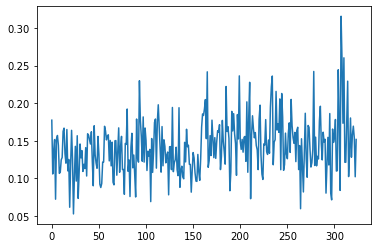

In [44]:
def make_dir_try(dir):
    try:
        os.makedirs(dir, exist_ok=True)
        print("Directory '%s' created successfully" % dir)
    except OSError as error:
        print("Directory '%s' can not be created" % dir)

plt.plot(np.average(top_rsp,axis=1))
directory = '../analysis/Graphs/PS_ratio_labeling_test_new/'+site+'/'
make_dir_try(directory)
directory = directory+'avg_rsp.jpg'
plt.savefig(directory)

In [9]:
#define some parameters to control how strict:
top_required = 8
max_ratio = 1.5
def check_max_valid (neuron, max_rsp):
    for index in top_indexes[neuron]:
        if PS_labels_all[index] < 2:
            if max_ratio*neuron_all_rsp[index, neuron] > max_rsp:
                return False
            else:
                return True
    return True

def majority_norm(num_list):
    count_list = np.zeros(6)
    for item in num_list:
        count_list[item] += 1
    max_idx = np.argmax(count_list)
    return max_idx

def majority_strict (num_list):
    count_list = np.zeros(6)
    for item in num_list:
        count_list[item] += 1
    max_idx = np.argmax(count_list)
    if count_list[max_idx] > len(num_list)*0.8 :
        return max_idx
    else :
        return -1
def majority_very_strict(neuron, num_list, max_rsp):
    for i in range(1,top_required):
        if not num_list[i] == num_list[i-1]:
            return -1
        if num_list[0] > 1 and not check_max_valid(neuron, max_rsp):
            return -1
    else :
        return num_list[0]
def majority_percent (neuron, top_idxs, top_percent):
    max_idx = top_idxs[0]
    max_rsp = neuron_all_rsp[max_idx,neuron]
    mixed_flag = False
    for idx in top_idxs:
        if neuron_all_rsp[idx, neuron] > top_percent*max_rsp:
            if not PS_labels_all[idx] == PS_labels_all[max_idx]:
                if PS_labels_all[max_idx] < 2:
                    return PS_labels_all[max_idx]
                elif PS_labels_all[idx] == 0:
                    return 0
                elif PS_labels_all[idx] == 1:
                    continue
                else:
                    mixed_flag = True
        else:
            break
    if mixed_flag == True:
        return 6
    return PS_labels_all[max_idx]

def majority_percent_vote (neuron, top_idxs, top_percent):
    max_idx = top_idxs[0]
    max_rsp = neuron_all_rsp[max_idx,neuron]
    all_voters = []
    for idx in top_idxs:
        if neuron_all_rsp[idx, neuron] > top_percent*max_rsp:
            all_voters.append(PS_labels_all[idx])
        else:
            break
    return majority_norm(all_voters)

In [45]:
all_model_all_neuron_labels = []
net_selected_num = []
for size, (top_indexes, top_rsp) in enumerate(zip(all_top_indexes,all_top_rsp)):
    channels = 256
    num_layers = 9
    input_size = 50
    output_size = num_neurons
    first_k = 9
    later_k = 3
    pool_size = 2
    factorized = True
    num_maps = 1

    net = BethgeModel(channels=channels, num_layers=num_layers, input_size=input_size,
                      output_size=output_size, first_k=first_k, later_k=later_k,
                      input_channels=1, pool_size=pool_size, factorized=True,
                      num_maps=num_maps).cuda()

    net.to(device)
    # net.load_state_dict(torch.load('D:/school/research/CNN_Tang_project/saved_models/Sample_size_test_models/'+str(size)+'_10_'+site+'_shared_core_256_9'))
    net.load_state_dict(torch.load(f'../saved_models/Sample_size_test_models/{size}_10_{site}_shared_core_256_9'))
    net.eval()

    Corr, _ = get_site_corr(net, device, site)
    selected_idx = []
    for i, c in enumerate(Corr):
        if c > 0:
            selected_idx.append(i)
    net_selected_num.append(len(selected_idx))
    num_iters = 10
    all_neuron_labels = np.full((num_iters, top_indexes.shape[0]), -1)
    label_names = ['SS', 'EB', 'CN', 'CV', 'CRS', 'Other', 'MC']

    for iter in tqdm(range(num_iters)):
        top_percent = 1-(0.5/num_iters)*(iter+1)
        neuron_labels = np.full(top_indexes.shape[0], -1)
        for neuron in selected_idx:
            neuron_top = top_indexes[neuron]
            neuron_top_rsp = top_rsp[neuron]
            all_labels = []
            for img_idx in neuron_top:
                label =  PS_labels_all[img_idx]
                all_labels.append(label)
            majority = majority_percent(neuron, neuron_top, top_percent)
            neuron_labels[neuron] = majority
        all_neuron_labels[iter] = neuron_labels
    all_model_all_neuron_labels.append(all_neuron_labels)

100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


In [37]:
#shape = all models, all metric level, all neuron
#all_model_all_neuron_labels = np.stack(all_model_all_neuron_labels)
all_model_all_neuron_labels = np.load('cosyne_dict_2.npy', allow_pickle=True).item()['m2s1']['label']

In [46]:
def count_labels (labels):
    label_count = np.zeros(7)
    for label in labels:
        if not label == -1:
            label_count[label] += 1
    return label_count
all_valid_ratios = np.zeros((10, num_iters))
all_label_counts = np.zeros((10, num_iters, 7))
for i, all_neuron_labels in enumerate(all_model_all_neuron_labels):
    num_considered = net_selected_num[i]
    #num_considered = 299
    for iter in range(num_iters):
        count = count_labels(all_neuron_labels[iter])
        ratio_labeled = 1 - (count[5]/all_neuron_labels.shape[1])
        all_valid_ratios[i, iter] = ratio_labeled
        all_label_counts[i, iter] = count/num_considered


def make_dir_try(dir):
    try:
        os.makedirs(dir, exist_ok=True)
        print("Directory '%s' created successfully" % dir)
    except OSError as error:
        print("Directory '%s' can not be created" % dir)

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


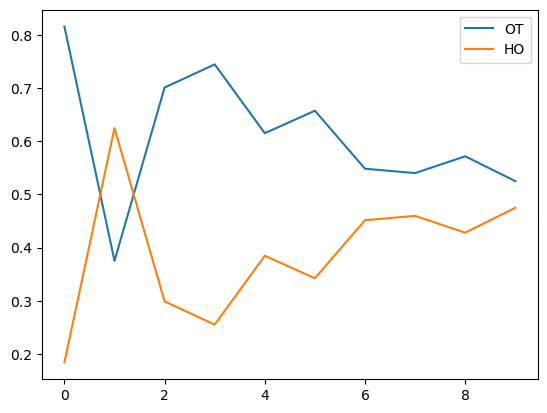

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


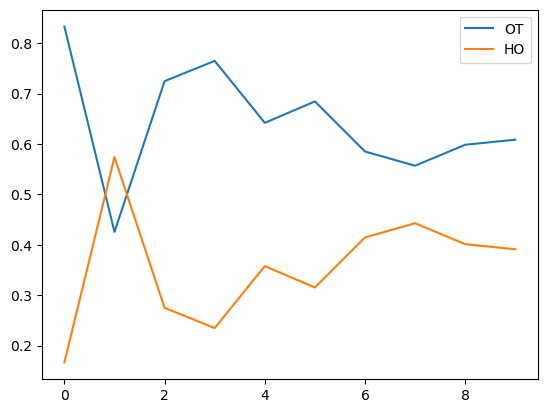

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


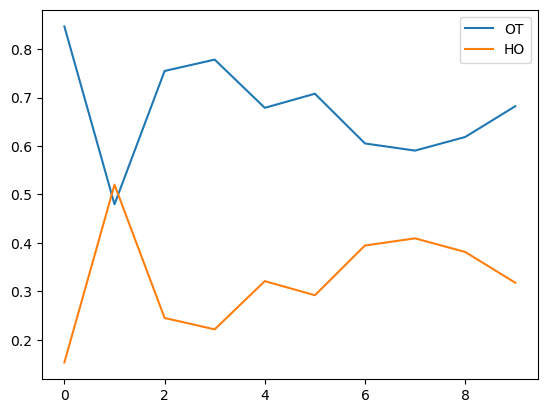

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


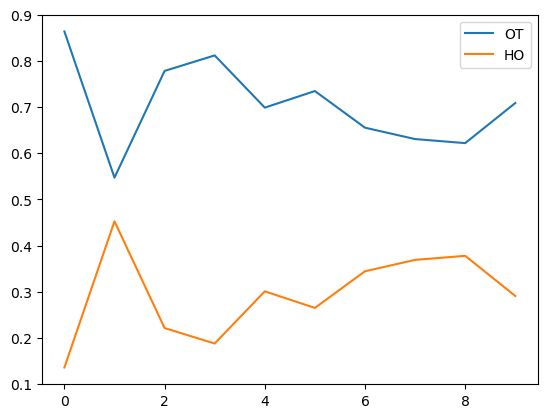

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


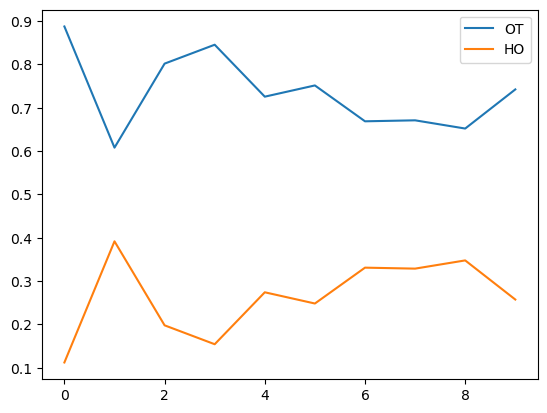

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


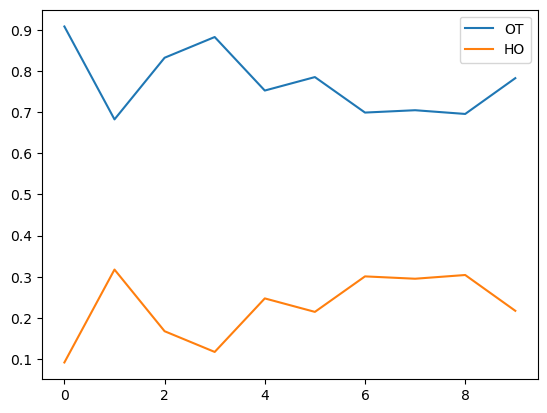

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


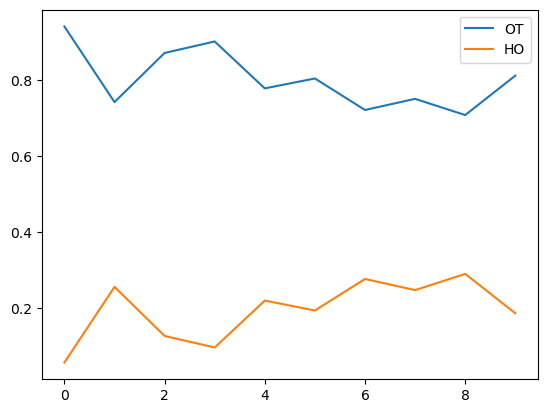

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


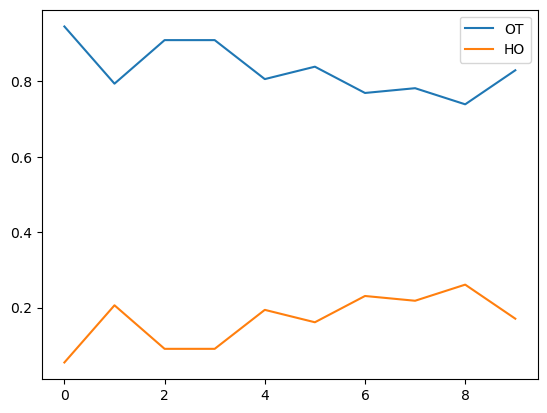

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


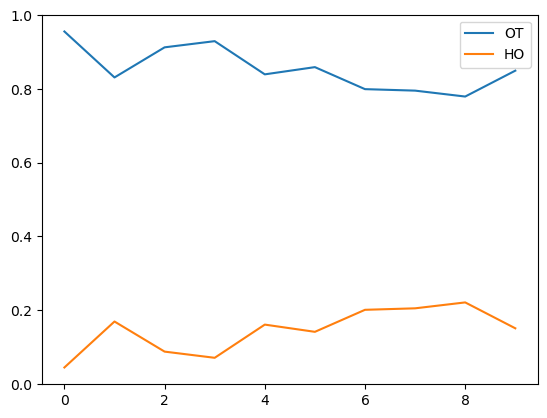

Directory '../analysis/Graphs/PS_complex_ratio_change/m2s1/newModel_0/' created successfully


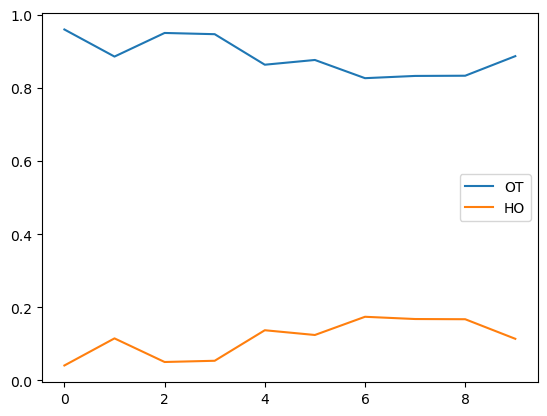

In [48]:
for iter in range(num_iters):

    directory = '../analysis/Graphs/PS_complex_ratio_change/'+site+'/' + 'newModel_0/'
    make_dir_try(directory)
    directory = directory+str(1-(0.5/num_iters)*(iter+1))+'.jpg'

    count_OT = np.sum(all_label_counts[:,iter,:2], axis=1)
    count_HO = np.sum(all_label_counts[:,iter,2:], axis=1)
    plt.plot(count_OT, label='OT')
    plt.plot(count_HO, label='HO')
    plt.legend()
    plt.savefig(directory)
    plt.show()

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.95/' created successfully


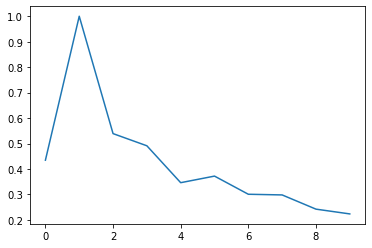

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.95/' created successfully


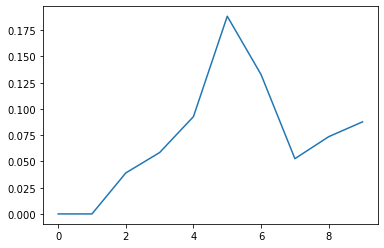

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.95/' created successfully


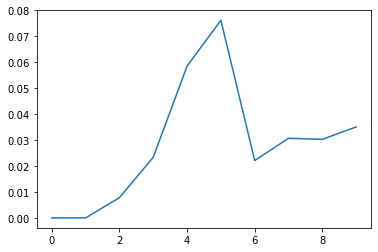

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.95/' created successfully


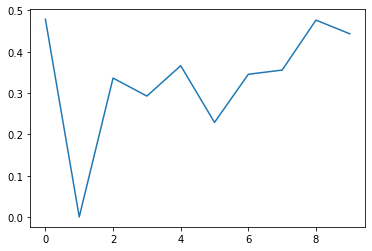

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.95/' created successfully


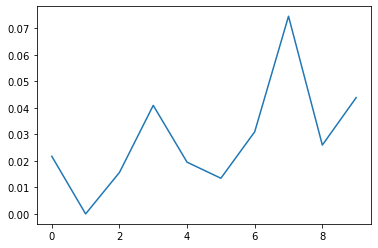

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.95/' created successfully


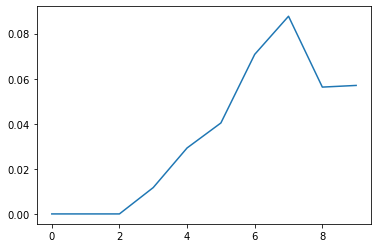

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.95/' created successfully


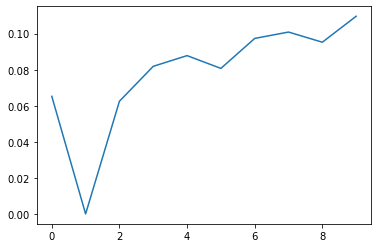

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.9/' created successfully


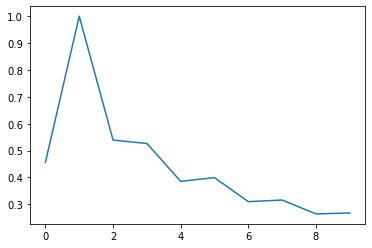

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.9/' created successfully


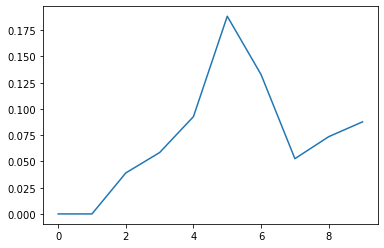

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.9/' created successfully


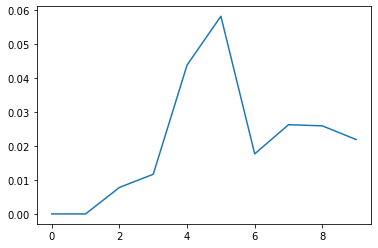

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.9/' created successfully


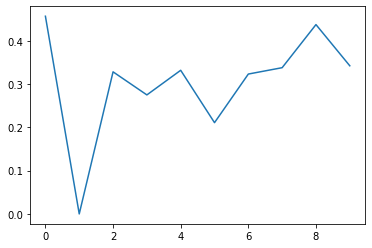

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.9/' created successfully


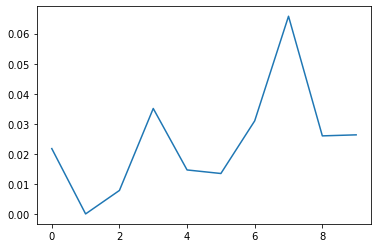

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.9/' created successfully


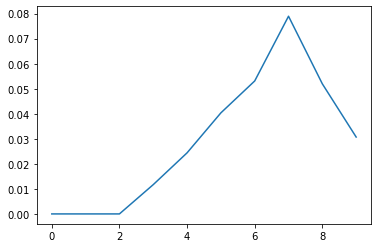

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.9/' created successfully


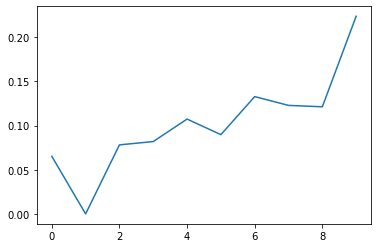

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.85/' created successfully


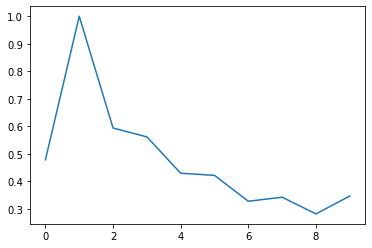

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.85/' created successfully


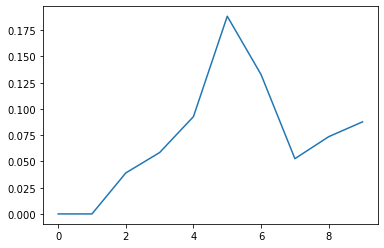

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.85/' created successfully


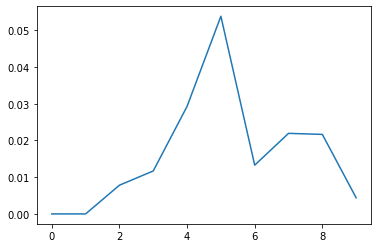

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.85/' created successfully


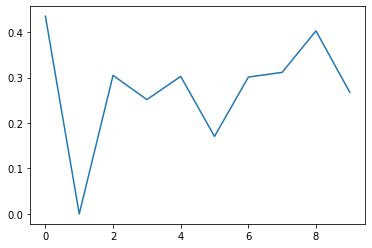

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.85/' created successfully


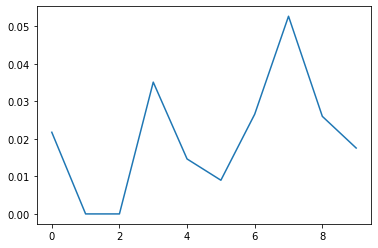

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.85/' created successfully


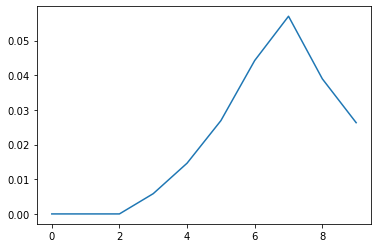

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.85/' created successfully


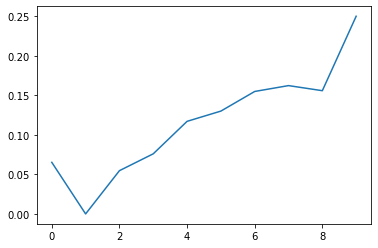

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.8/' created successfully


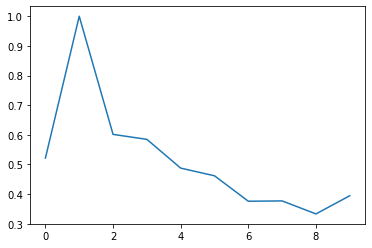

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.8/' created successfully


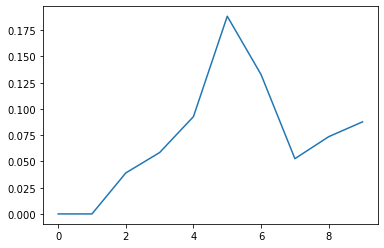

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.8/' created successfully


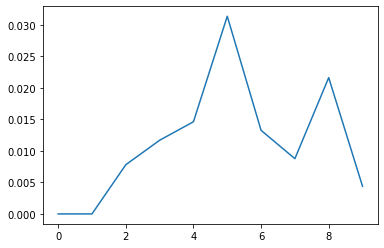

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.8/' created successfully


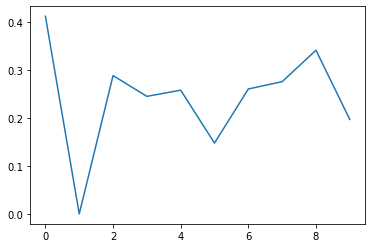

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.8/' created successfully


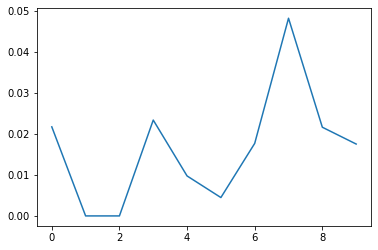

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.8/' created successfully


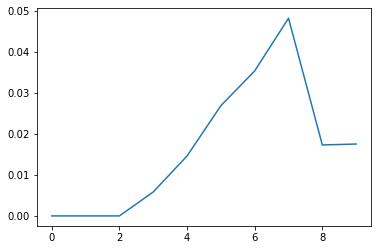

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.8/' created successfully


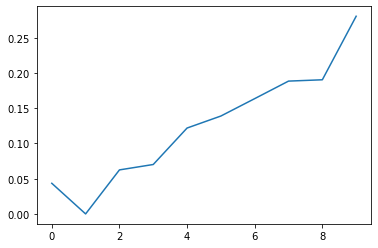

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.75/' created successfully


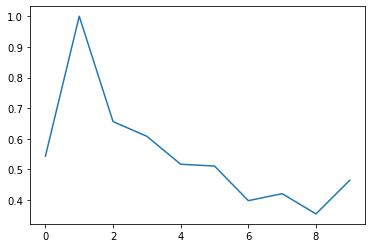

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.75/' created successfully


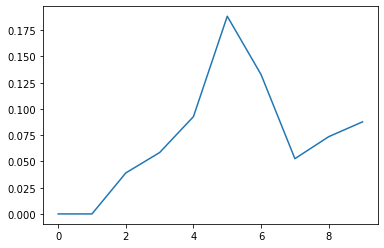

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.75/' created successfully


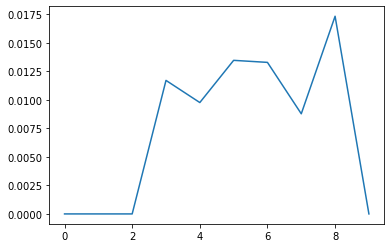

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.75/' created successfully


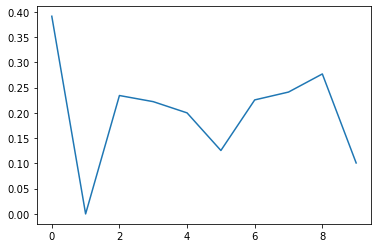

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.75/' created successfully


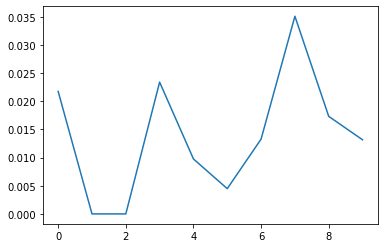

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.75/' created successfully


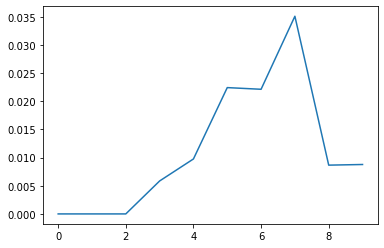

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.75/' created successfully


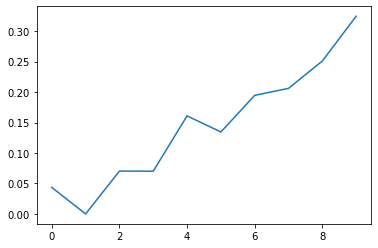

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.7/' created successfully


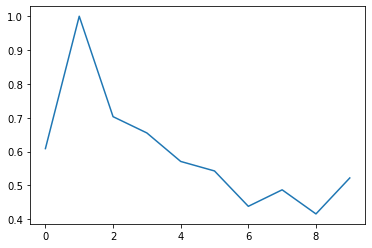

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.7/' created successfully


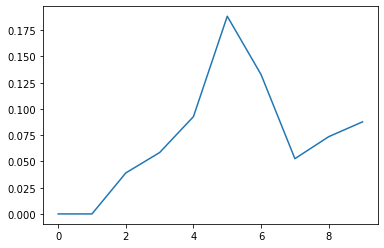

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.7/' created successfully


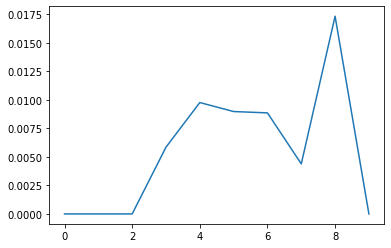

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.7/' created successfully


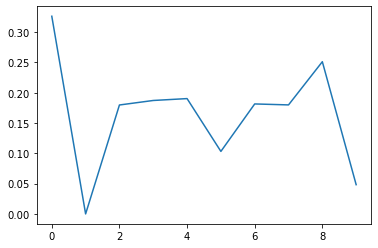

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.7/' created successfully


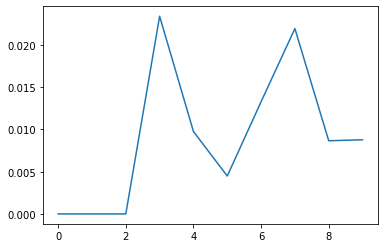

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.7/' created successfully


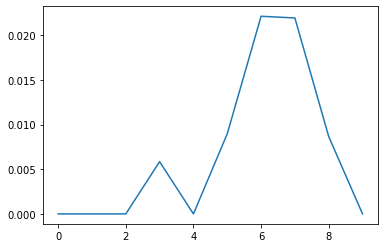

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.7/' created successfully


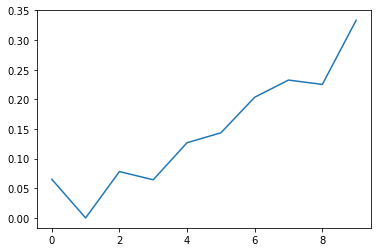

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6499999999999999/' created successfully


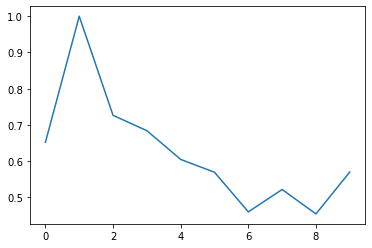

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6499999999999999/' created successfully


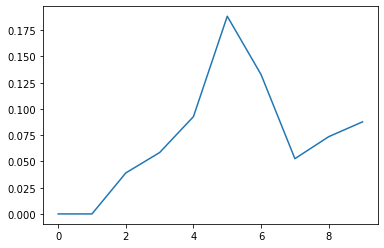

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6499999999999999/' created successfully


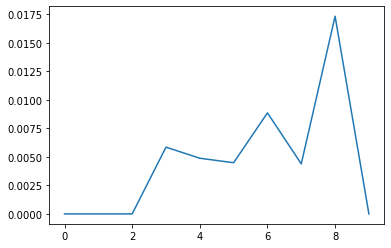

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6499999999999999/' created successfully


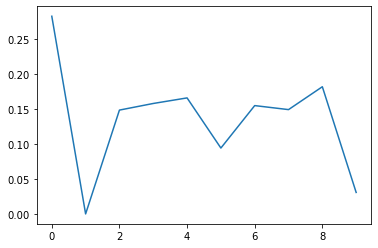

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6499999999999999/' created successfully


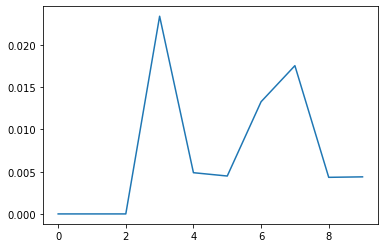

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6499999999999999/' created successfully


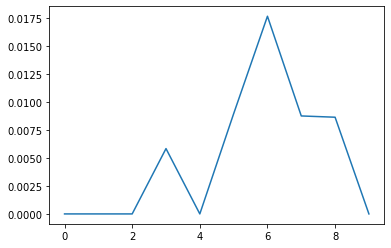

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6499999999999999/' created successfully


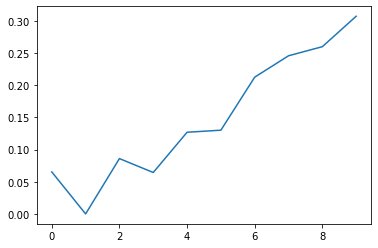

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6/' created successfully


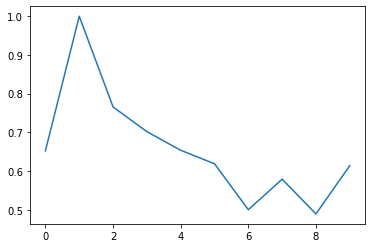

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6/' created successfully


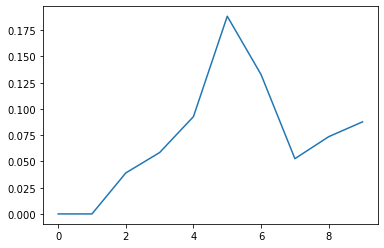

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6/' created successfully


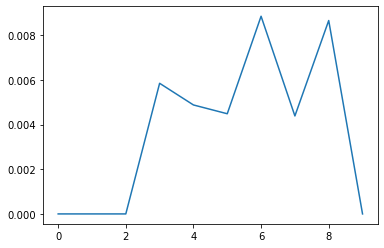

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6/' created successfully


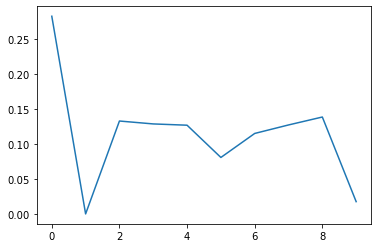

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6/' created successfully


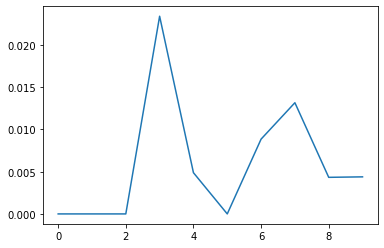

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6/' created successfully


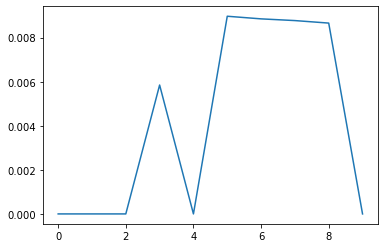

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.6/' created successfully


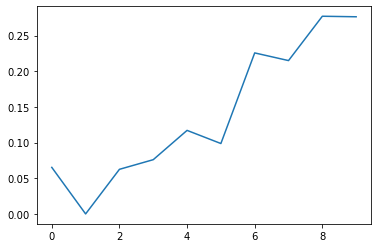

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.55/' created successfully


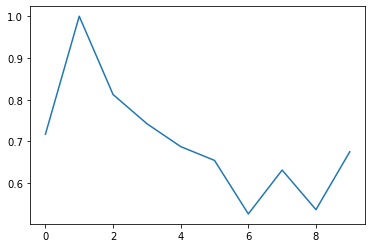

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.55/' created successfully


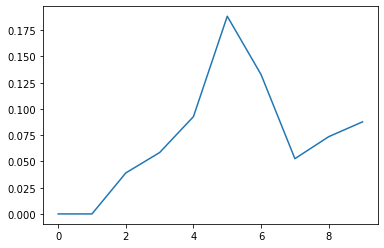

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.55/' created successfully


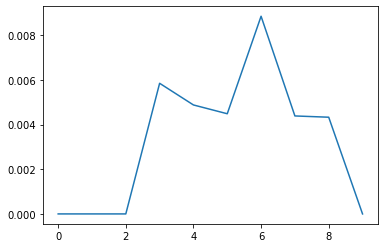

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.55/' created successfully


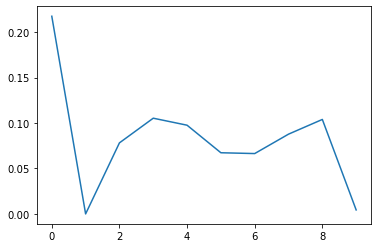

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.55/' created successfully


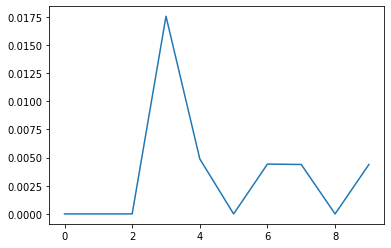

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.55/' created successfully


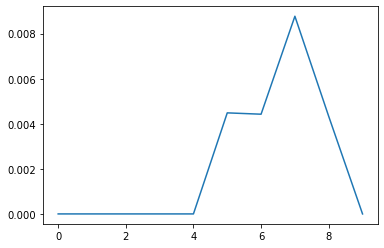

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.55/' created successfully


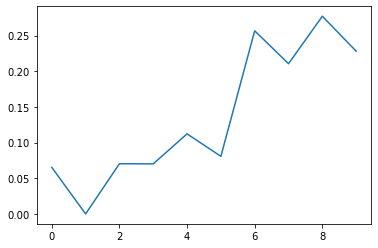

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.5/' created successfully


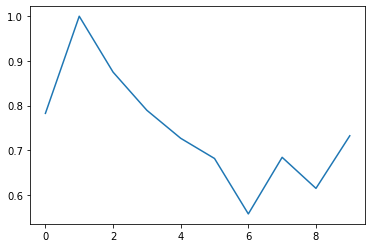

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.5/' created successfully


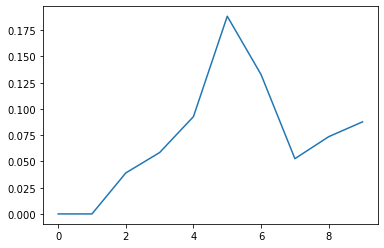

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.5/' created successfully


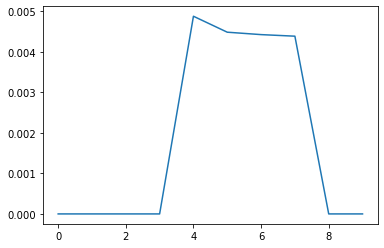

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.5/' created successfully


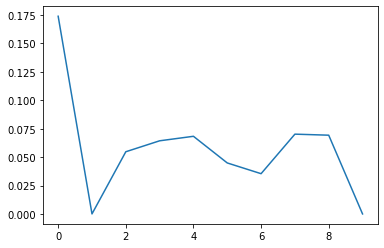

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.5/' created successfully


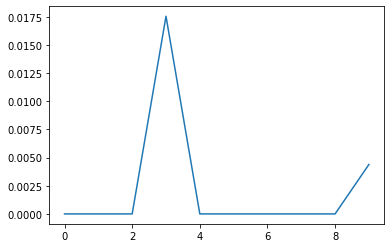

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.5/' created successfully


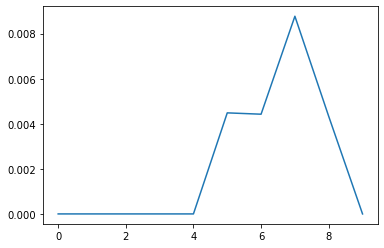

Directory '../analysis/Graphs/PS_ratio_labeling_across_models/m2s1/eb_no_veto/top_percent_0.5/' created successfully


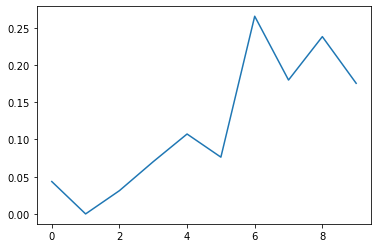

In [23]:
for iter in range(num_iters):
    for label_index, label in enumerate(label_names):
        directory = '../analysis/Graphs/PS_ratio_labeling_across_models/'+site+'/eb_no_veto/' + 'top_percent_' +str(1-(0.5/num_iters)*(iter+1))+'/'
        make_dir_try(directory)
        directory = directory+label+'.jpg'
        plt.plot(all_label_counts[:,iter,label_index])
        plt.savefig(directory)
        plt.show()

In [ ]:
for iter in range(num_iters):
    fig1, ax1 = plt.subplots()
    ax1.pie(all_label_counts[iter], labels=label_names, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')
    directory = '../analysis/Graphs/PS_ratio_labeling_test_new/'+site+'/'
    make_dir_try(directory)
    directory = directory+str(iter)+'.jpg'
    plt.savefig(directory)
    plt.show()

directory_base = '../analysis/Graphs/PS_ratio_labeling_test_new/'+site+'/'
directory = directory_base+'percent_labeled_data.jpg'
plt.figure()
x_ratios = [1-(0.5/num_iters)*(iter+1) for iter in range(num_iters)]
plt.plot(x_ratios, all_valid_ratios)
plt.savefig(directory)


all_complex_ratio = []
all_num_labeled  = []
for iter in range(num_iters):
    count = all_label_counts[iter]
    num_labeled = num_neurons - count[5]
    complex_ratio = 1-(count[0]/num_labeled)
    if num_labeled == 0:
        complex_ratio = 0
    all_complex_ratio.append(complex_ratio)
    all_num_labeled.append(num_labeled)

plt.figure()
plt.plot(x_ratios, all_complex_ratio)
directory = directory_base+'complex_ratio.jpg'
plt.savefig(directory)

plt.figure()
plt.plot(x_ratios, all_num_labeled)
directory = directory_base+'num_labeled.jpg'
plt.savefig(directory)